In [ ]:
import pandas as pd
import nltk
nltk.download('stopwords')
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import re
import plotly.express as px
from wordcloud import WordCloud
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
data = pd.read_excel('train_derailment_area_tweets_18_days.xlsx')
data.shape

(103661, 54)

In [ ]:
data.duplicated().sum()

0

In [ ]:
data.head()

,tweet_id,timestamp_ms,created_at,date_string,city_state,city,state,long_point,lat_point,long_estim,...,quoted_status_user_favs,quoted_status_user_joined,quoted_status_user_lang,quoted_status_user_user_name,quoted_status_user_user_loc,quoted_status_user_user_bio,quoted_status_tweet_text,quoted_status_link_in_tweet_domain_short,quoted_status_link_in_tweet_domain_long,quoted_status_link_in_tweet
0,1620648138930556930,1675227601164,2023-02-01 05:00:01,2023-02-01,"Warren, OH",Warren,OH,0.0,0.0,-80.81724,...,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1620648161462358016,1675227606536,2023-02-01 05:00:06,2023-02-01,"Euclid, OH",Euclid,OH,0.0,0.0,-81.52048,...,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1620648202851725312,1675227616404,2023-02-01 05:00:16,2023-02-01,"Jefferson, OH",Jefferson,OH,0.0,0.0,-82.80247,...,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1620648299429769216,1675227639430,2023-02-01 05:00:39,2023-02-01,"Painesville, OH",Painesville,OH,0.0,0.0,-81.25318,...,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1620648531177664514,1675227694683,2023-02-01 05:01:34,2023-02-01,"Cleveland, OH",Cleveland,OH,0.0,0.0,-81.70547,...,6397.0,2012-02-03 01:15:24,en,feem j. meem,NaN,NEVER GREW UP | they/them | smash computer | i...,@ronnui_ @MNateShyamalan wonderwall,NaN,NaN,NaN


### Words filtering

22621 - 2

2/4/2023 19:12:15

East Palestine, OH

Presser just wrapped in East Palestine. Takeaways: Residence continue to shelter in place till further notice. Scene is still dangerous. Waiting on Norfolk Southern to clear scene for FD to put out fire. Vinyl chloride was on train. Air quality still safe in village.

Search: Norfolk

96991 - 2

2/17/2023 00:19:25

East Palestine, OH

@MaryBeth1BR @AF_okjody The EPA are bought and paid for by Norfolk Southern! Hell, they were here and helped make the decision to set these train cars on fire! All in my opinion, to clear the tracks faster so they could run their trains back up and running faster.


#### Preprocessing

In [ ]:
#https://ourcodingclub.github.io/tutorials/topic-modelling-python/

def remove_links(tweet):
  tweet = re.sub(r'http\S+', '', tweet)
  tweet = re.sub(r'bit.ly/\S+', '', tweet)
  tweet = tweet.strip('[link]')
  return tweet

def remove_users(tweet):
  tweet = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)
  tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)
  return tweet

In [ ]:
my_stopwords = nltk.corpus.stopwords.words('english')
word_rooter = nltk.stem.snowball.PorterStemmer(ignore_stopwords=False).stem
my_punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@'

# cleaning master function
def clean_tweet(tweet, bigrams=False):
    tweet = remove_users(tweet)
    tweet = remove_links(tweet)
    tweet = tweet.lower() # lower case
    tweet = re.sub('['+my_punctuation + ']+', ' ', tweet) # strip punctuation
    tweet = re.sub('\s+', ' ', tweet) #remove double spacing
    tweet = re.sub('([0-9]+)', '', tweet) # remove numbers
    tweet_token_list = [word for word in tweet.split(' ')
                            if word not in my_stopwords] # remove stopwords

    #tweet_token_list = [word_rooter(word) if '#' not in word else word for word in tweet_token_list] # apply word rooter

    if bigrams:
        tweet_token_list = tweet_token_list+[tweet_token_list[i]+'_'+tweet_token_list[i+1]
                                            for i in range(len(tweet_token_list)-1)]
    tweet = ' '.join(tweet_token_list)
    return tweet

In [ ]:
#data['tweet_text'].shape[0]
data['tweet_text'].isna().sum()

533

In [ ]:
data['all_tweets'] = data['tweet_text'].copy(deep=True)
data['all_tweets'] = data['all_tweets'].fillna(data['quoted_status_tweet_text'])
#data = data.dropna(subset=['tweet_text'])
#data['tweet_text'].shape[0]

In [ ]:
data['all_tweets'].isna().sum() #61 rows with no tweet_text and quoted_status_tweet_text
data = data.dropna(subset=['all_tweets'])

In [ ]:
data['clean_tweet'] = data.all_tweets.apply(clean_tweet)

#### Single word match

In [ ]:
keywords = ['norfolk', 'derail', 'palestine', 'vinyl', 'evacuat', 'chemical'] #derail - derailment, derailed #evacut - evacuate, evacuation
akeywords = []
train_derailment_data = pd.DataFrame(columns = data.columns)

def filter_tweet(keywords, tweet):
  for word in keywords:
    tweet_list = tweet.split(' ')
    for ele in tweet_list:
      if word in ele:
        return True
  return False


for row_num in range(data.shape[0]):
  if filter_tweet(keywords, data.iloc[row_num][data.columns.get_loc("clean_tweet")]):
        train_derailment_data.loc[len(train_derailment_data)] = list(data.iloc[row_num])

In [ ]:
train_derailment_data.shape

(722, 56)

In [ ]:
train_derailment_data.shape[0] / data.shape[0] * 100

0.6969111969111969

#### Phrase matching

In [ ]:
'''
#2023 Ohio train derailment topic tweets separation

phrase_count = {('train', 'derailment'): 0,
                       ('east', 'palestine'): 0,
                       ('vinyl', 'chloride'): 0,
                       ('norfolk', 'southern'): 0}

def topic_check(tweet):
  global phrase_count
  match_phrases = list(phrase_count.keys())
  for phrase in match_phrases:
    match = list()
    for word in phrase:
      match.append(word in tweet)
    if match == [True] * len(phrase):
      #print(phrase, tweet)
      phrase_count[phrase] += 1
      return True
  return False
'''

"\n#2023 Ohio train derailment topic tweets separation\n\nphrase_count = {('train', 'derailment'): 0, \n                       ('east', 'palestine'): 0, \n                       ('vinyl', 'chloride'): 0, \n                       ('norfolk', 'southern'): 0}\n\ndef topic_check(tweet):\n  global phrase_count\n  match_phrases = list(phrase_count.keys())\n  for phrase in match_phrases:\n    match = list()\n    for word in phrase:\n      match.append(word in tweet)\n    if match == [True] * len(phrase): \n      #print(phrase, tweet)\n      phrase_count[phrase] += 1 \n      return True\n  return False\n"

In [ ]:
#testing topic_check
#topic_check('hello east palestine norfolk')

In [ ]:
'''
train_derailment_data = pd.DataFrame(columns = data.columns)

for row_num in range(data.shape[0]):
  tweet_ = data.iloc[row_num][data.columns.get_loc("clean_tweet")]
  if topic_check(tweet_): train_derailment_data.loc[len(train_derailment_data)] = list(data.iloc[row_num])

phrase_count
'''

'\ntrain_derailment_data = pd.DataFrame(columns = data.columns)\n\nfor row_num in range(data.shape[0]):\n  tweet_ = data.iloc[row_num][data.columns.get_loc("clean_tweet")]\n  if topic_check(tweet_): train_derailment_data.loc[len(train_derailment_data)] = list(data.iloc[row_num])\n\nphrase_count\n'

In [ ]:
#train_derailment_data.to_csv('train_derailment_data.csv')

### Analysis on all tweets - cleaned

In [ ]:
data['clean_tweet'].to_csv('clean_tweets.csv')

In [ ]:
train_derailment_data.to_csv('train_derailment_tweets.csv')

In [ ]:
#removing first 14 records since they are not related to ohio train derailment topic

train_derailment_data = train_derailment_data.loc[14:, :]

In [ ]:
text = train_derailment_data['clean_tweet'].values
total = str(text).replace('\n ', "")
total = re.sub('['+my_punctuation + ']+', ' ', total)
#total

#### Word clouds for all tweets texts, only words and only hashtags

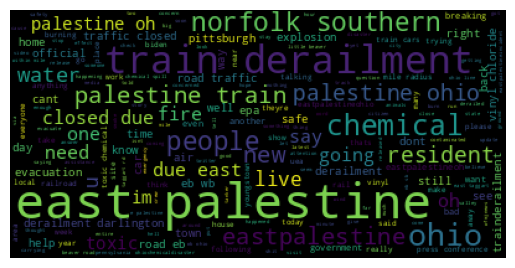

In [ ]:
wordcloud = WordCloud().generate(total)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

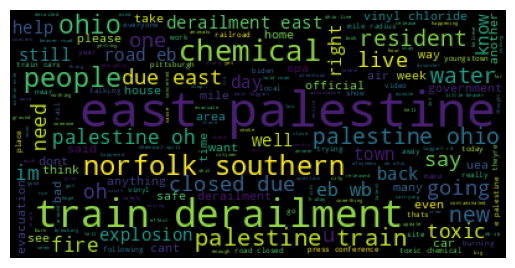

In [ ]:
words = [word for word in total.split(' ') if '#' not in word]
words = ' '.join(words)

wordcloud = WordCloud().generate(words)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

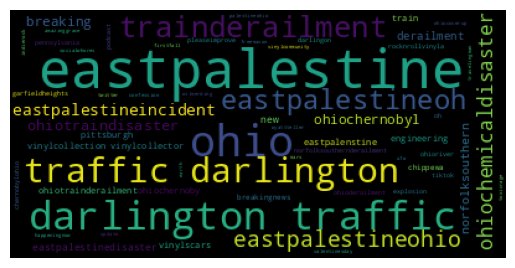

In [ ]:
hashtags = [word for word in total.split(' ') if '#' in word]
hashtags = ' '.join(hashtags)

wordcloud = WordCloud().generate(hashtags)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

#### Date wise tweet count trend

In [ ]:
temp = train_derailment_data['date_string'].value_counts().reset_index()
temp = temp.sort_values(by = ['index'])
temp.columns = ['date_string', 'tweet counts']
temp

,date_string,tweet counts
7,2023-02-04,35
13,2023-02-05,10
4,2023-02-06,66
6,2023-02-07,49
8,2023-02-08,30
11,2023-02-09,11
14,2023-02-10,10
10,2023-02-11,14
9,2023-02-12,21
5,2023-02-13,63


In [ ]:
fig = px.line(temp, x = 'date_string', y = 'tweet counts', title='Tweet frequency over days')

fig.show()

In [ ]:
data_temp = data['date_string'].value_counts().reset_index()
data_temp = data_temp.sort_values(by = ['index'])
data_temp.columns = ['date_string', 'tweet counts']
data_temp

,date_string,tweet counts
16,2023-02-01,4568
4,2023-02-02,6554
0,2023-02-03,6945
5,2023-02-04,6266
7,2023-02-05,6038
6,2023-02-06,6218
8,2023-02-07,6015
3,2023-02-08,6682
2,2023-02-09,6692
10,2023-02-10,5884


In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = temp["date_string"], y = temp['tweet counts'], name = 'Train derailment', mode="lines"))
fig.add_trace(go.Scatter(x = data_temp["date_string"], y = data_temp['tweet counts'], name = 'All', mode="lines"))
fig.update_layout(
    title="Tweet frequency over days", xaxis_title="Date", yaxis_title="Number of tweets"
)
fig.show()

#### Tweet counts per city

In [ ]:
train_derailment_data['city'].value_counts()

East Palestine    151
Pittsburgh         68
Cleveland          59
Youngstown         41
Akron              22
                 ... 
West Newton         1
Leetsdale           1
New Waterford       1
Aurora              1
Greensburg          1
Name: city, Length: 116, dtype: int64

#### Tweets counts per username

In [ ]:
data['user_name'].value_counts()

                    1347
Black Jesus         1229
Robert Hughes        788
TTWN Cleveland       724
Not the Father       621
                    ... 
pete griffin           1
Loganberry Books       1
Gigi Hebrank           1
Emily Wenzell          1
Colin                  1
Name: user_name, Length: 8611, dtype: int64

In [ ]:
train_derailment_data['user_name'].value_counts()

TTWN Pittsburgh                                40
Mindy Slaven                                   31
Nick Sortor                                    17
Neil Fischer                                   15
USEmergAlerts Incident Notification Service    15
                                               ..
G Dog.                                          1
g                                               1
Gary Hargreaves                                 1
ElizabethMacPherson                             1
HomeVisitor                                     1
Name: user_name, Length: 331, dtype: int64

In [ ]:
#profiles of active accounts - [name, no.of tweets, location, following, followers]
temp = train_derailment_data['user_name'].value_counts().reset_index()
temp.columns = ['user_name', 'tweet count']

temp2 = train_derailment_data.drop_duplicates('user_name', keep='last')
temp.merge(temp2[['user_name', 'user_bio', 'followers', 'following', 'ff_ratio']], how='left', on='user_name').head(10)

,user_name,tweet count,user_bio,followers,following,ff_ratio
0,TTWN Pittsburgh,40,Providing accurate & reliable real-time traffi...,4713,44,107.114
1,Mindy Slaven,31,"Youngstown State University Alumni (B.A.J), Li...",318,5000,0.064
2,Nick Sortor,17,"Accidental journalist, software engineer, and ...",79177,15922,4.973
3,Neil Fischer,15,@wkyc Reporter | Email: nfischer@wkyc.com | Cl...,1397,489,2.857
4,USEmergAlerts Incident Notification Service,15,USEmergAlerts National Incident Networks bring...,986,959,1.028
5,Bill Labovitz,12,"Husband, father of 3 & reporter-turned-attorne...",1683,4973,0.338
6,Paul Gregory,12,Retired,6,46,0.130
7,Matt Geiser,11,"Singer, bassist, song writer and music produce...",207,67,3.090
8,timbownan,10,Good health is your greatest strength happy ma...,39349,2756,14.278
9,Erin Simonek,9,11 p.m. Weekday Anchor/ Nightside Reporter @21...,936,317,2.953


#### Quoted tweets

In [ ]:
#Quoted tweets with frequency more than 1

pd.DataFrame(data['quoted_status_tweet_text'].value_counts())

,quoted_status_tweet_text
Truly grateful on this day. Thank you https://t.co/j2s2sezvSS,31
I dont know who needs to hear this but: Change the battery on your smoke detector TODAY! Were tired of hearing it over here,22
Former NFL player arian foster admits NFL is literaly rigged https://t.co/RSfqF1OwKI,12
"Breaking: Brooklyn Nets All-Star Kyrie Irving has requested a trade, league sources tell @TheAthletic @Stadium. The franchise has been informed that Irving prefers to move on ahead of the Feb. 9 trade deadline or will leave in free agency in July.",9
Greene: Can you tell me how much money went to CRT? Dodaro: CRT? Greene: Its a racist curriculum used to teach children that somehow their white skin not equal to black skin and other things https://t.co/ssFZE7Gxlz,7
...,...
Yall know exactly what happened when I opened this plate https://t.co/oPay0V4QRu,1
Jay Williams and Stephen A. Smith get into it over Kyrie Irving https://t.co/2nmNAaMX2y,1
"It annoys me that the Baltimore Ravens won Trent Dilfer a Super Bowl ring. The way he talks about modern day QBs, youd assume he was all-pro. In reality, hes Brian Hoyer with Aaron Rodgers ego.",1
"the Pro Bowl was Joes second home we'll find out Thursday if hell have a home in Canton (NFL Honors, 9 p.m. ET) https://t.co/dHSDAJs5vi",1


In [ ]:
#Most quoted texts regarding ohio train derailment

pd.DataFrame(train_derailment_data['quoted_status_tweet_text'].value_counts())

,quoted_status_tweet_text
East Palestine: Residents living within a mile of the train derailment site who have not yet left their homes are asked to immediately evacuate due to the potential of a major explosion. https://t.co/F2BWmBipPx,3
"#BREAKING: Shelter in place has a been issued due hazardous toxic chemicals leaking #Tucson | #Arizona Currently authorities have issued a hazmat alert and a 'shelter in place' warning is in effect for all individuals within a mile radius in Tucson Arizona, after a truck https://t.co/F4UjjGtgYN",2
"East Palestine: New water testing results show no detection of contaminants in East Palestines municipal water system. With these test results, @OhioEPA is confident that the municipal water is safe to drink.",2
Even MORE proof that the EPA is LYING to the people of East Palestine. THIS WATER IS INSANELY CONTAMINATED. https://t.co/rNlNxxBTDd,2
Visited a local creek in East Palestine today. These waterways are still very polluted. Its time for Norfolk Southern to finish the cleanup. Check this video out: https://t.co/4lsHBmrMJj,2
...,...
Probably the best video about what happened in Pennsylvania/Ohio and its pretty mind blowing. https://t.co/VbG0kzplRs,1
"After a train derailment, East Palestine, Ohio residents are worried about returning home after their town was covered with toxic chemicals. Now, there are concerns that there were other chemicals being carried on that train. Watch #MorninginAmerica: https://t.co/yfclYlX83X https://t.co/iY2PzLZoLP",1
"@CrazyAmerican @realstewpeters SW Ohio here, and there has been zero reporting on it. Went to lunch with some friends in Cincinnati today, they hadnt heard anything about any train derailment, and were shocked when I told them.",1
OHIO: This is whats happening to cars after driving through spurts of rain70+ MILES SE OF THE EAST PALESTINE INCIDENT! https://t.co/5QwXWg6mwU,1


#### Overall followers - following trend

<Axes: xlabel='following', ylabel='followers'>

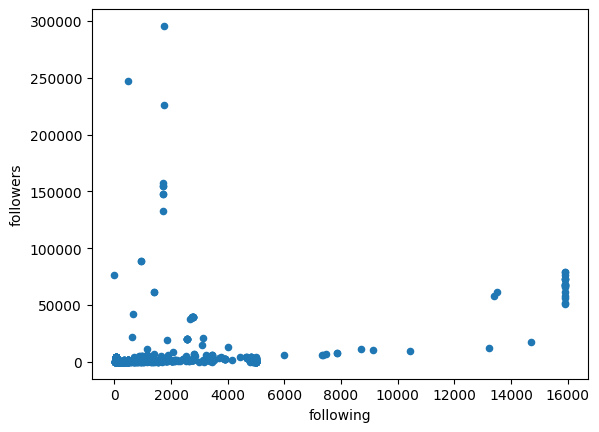

In [ ]:
#followers/following -> ff_ratio

train_derailment_data.plot.scatter(x='following',  y = 'followers')

#log-log scale

In [ ]:
#more effective ways to extract data to increase the actual subset of the data

#nation vs local

#bio and information spread

#other social media contents

#topic detection or classifier extensions

#luminaries - which luminaries were common in different locations.
##Identifying them would help to target the faster ways to spread information